# SSGP

Port of GPJax's implementation: https://docs.jaxgaussianprocesses.com/_examples/uncollapsed_vi/

From this paper: https://arxiv.org/abs/1309.6835

GPjax is pip installable.

In [1]:
import os

#XLA_FLAGS="--xla_force_host_platform_device_count=8"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
import jax
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

In [2]:
from jax import config
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox
import numpy as np
import tensorflow_probability.substrates.jax as tfp

from examples.utils import use_mpl_style

config.update("jax_enable_x64", True)


with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
    import gpjax.kernels as jk


tfb = tfp.bijectors

key = jr.key(123)

# set the default style for plotting
use_mpl_style()
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

# simulated data set

In [3]:
n = 50_000
noise = 0.2

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-5.0, maxval=5.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise
D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-5.5, 5.5, 500).reshape(-1, 1)

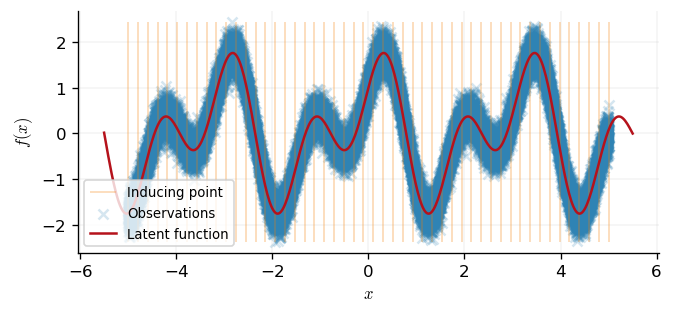

In [4]:
z = jnp.linspace(-5.0, 5.0, 50).reshape(-1, 1)

fig, ax = plt.subplots()
ax.vlines(
    z,
    ymin=y.min(),
    ymax=y.max(),
    alpha=0.3,
    linewidth=1,
    label="Inducing point",
    color=cols[2],
)
ax.scatter(x, y, alpha=0.2, color=cols[0], label="Observations")
ax.plot(xtest, f(xtest), color=cols[1], label="Latent function")
ax.legend()
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$");

In [11]:
meanf = gpx.mean_functions.Zero()
likelihood = gpx.likelihoods.Gaussian(num_datapoints=n)
kernel = jk.RBF()  # 1-dimensional inputs
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
p = prior * likelihood
q = gpx.variational_families.VariationalGaussian(posterior=p, inducing_inputs=z)

from gpjax.dataset import Dataset
D2 = Dataset(D.X[::20, :], D.y[::20])

gpx.objectives.elbo(q, D2)

Array(-14298073.14163967, dtype=float64)

In [57]:
%%timeit

gpx.objectives.elbo(q, D2)

139 ms ± 54.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Train

In [12]:
schedule = ox.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=0.02,
    warmup_steps=75,
    decay_steps=2000,
    end_value=0.001,
)

opt_posterior, history = gpx.fit(
    model=q,
    # we are minimizing the elbo so we negate it
    objective=lambda p, d: -gpx.objectives.elbo(p, d),
    train_data=D,
    optim=ox.adam(learning_rate=schedule),
    num_iters=10_000 * 500 // 50_000,
    key=jr.key(42),
    batch_size=500,
)

  0%|          | 0/100 [00:00<?, ?it/s]

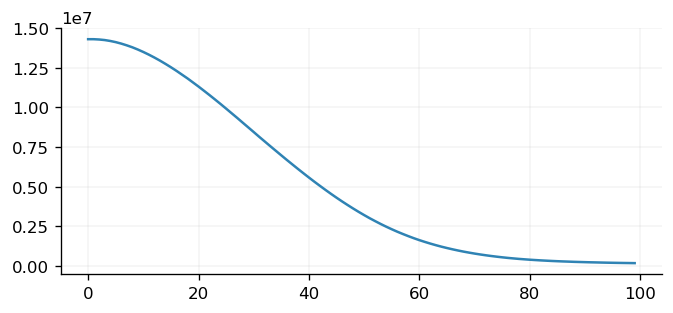

In [13]:
plt.plot(history)

In [17]:
history[-1]

Array(187326.76493039, dtype=float64)

# Generate predictions

In [11]:
latent_dist = opt_posterior(xtest)
predictive_dist = opt_posterior.posterior.likelihood(latent_dist)

meanf = predictive_dist.mean()
sigma = predictive_dist.stddev()

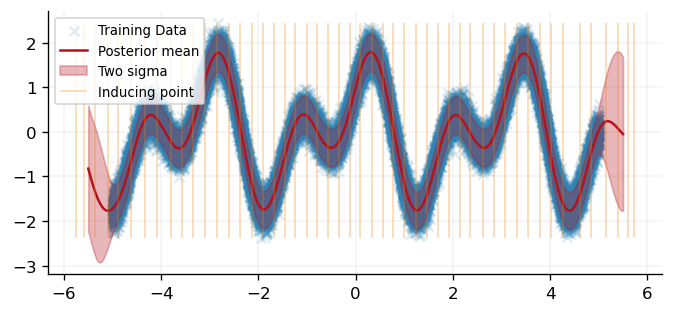

In [13]:
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.15, label="Training Data", color=cols[0])
ax.plot(xtest, meanf, label="Posterior mean", color=cols[1])
ax.fill_between(
    xtest.flatten(),
    meanf - 2 * sigma,
    meanf + 2 * sigma,
    alpha=0.3,
    color=cols[1],
    label="Two sigma",
)
ax.vlines(
    opt_posterior.inducing_inputs.value,
    ymin=y.min(),
    ymax=y.max(),
    alpha=0.3,
    linewidth=1,
    label="Inducing point",
    color=cols[2],
)
ax.legend();

# (Very) rough port of implementation

In [6]:
import pymc as pm
import pytensor
import pytensor.tensor as pt
from pymc.gp.util import stabilize

Xd = np.asarray(D.X)
yd = np.asarray(D.y)


class VariationalGaussian:
    def __init__(
        self,
        mean_func,
        cov_func,
        inducing_inputs,
        variational_mean,
        variational_root_covariance,
        jitter=1e-6
    ):
        self.mean_func = mean_func
        self.cov_func = cov_func
        self.inducing_inputs = inducing_inputs
        self.variational_mean = variational_mean
        self.variational_root_covariance = variational_root_covariance

    def kl_divergence(self):
        mu = self.variational_mean
        sqrt = self.variational_root_covariance
        z = self.inducing_inputs

        muz = self.mean_func(z)
        Kzz = self.cov_func(z)
        return self.kl_mvn(mu.flatten(), sqrt, muz, Kzz)

    @staticmethod
    def kl_mvn(mu1, K1, mu2, K2):
        d = mu2 - mu1
    
        K1 = stabilize(K1)
        K2 = stabilize(K2)
        
        L1 = pt.linalg.cholesky(K1, lower=True)
        L2 = pt.linalg.cholesky(K2, lower=True)
    
        logdet1 = 2 * pt.sum(pt.log(pt.diag(L1)))
        logdet2 = 2 * pt.sum(pt.log(pt.diag(L2)))
    
        def solve(B):
            return pt.linalg.solve_triangular(L2.T, pt.linalg.solve_triangular(L2, B, lower=True), lower=False)
        
        term1 = pt.trace(solve(K1))
        term2 = logdet2 - logdet1
        term3 = d.T @ solve(d)
        return ((term1 + term2 + term3 - d.shape[0]) / 2.0)

    def predict(self, t):
        mu = self.variational_mean.flatten()
        sqrt = self.variational_root_covariance
        z = self.inducing_inputs

        muz = self.mean_func(z)
        Kzz = stabilize(self.cov_func(z))
        Lz = pt.linalg.cholesky(Kzz)

        Ktt = stabilize(self.cov_func(t))
        Kzt = self.cov_func(z, t)
        mut = self.mean_func(t)

        Lz_inv_Kzt = pt.linalg.solve_triangular(Lz, Kzt, lower=True) # Lz⁻¹ Kzt
        Kzz_inv_Kzt = pt.linalg.solve_triangular(Lz.T, Lz_inv_Kzt, lower=False) # Kzz⁻¹ Kzt
        Ktz_Kzz_inv_sqrt = pt.matmul(Kzz_inv_Kzt.T, sqrt) # Ktz Kzz⁻¹ sqrt

        mean = mut + pt.matmul(Kzz_inv_Kzt.T, mu - muz) # μt + Ktz Kzz⁻¹ (μ - μz)
        covariance = stabilize(
            Ktt -
            pt.matmul(Lz_inv_Kzt.T, Lz_inv_Kzt) + 
            pt.matmul(Ktz_Kzz_inv_sqrt, Ktz_Kzz_inv_sqrt.T)
        )
        return mean, covariance
        #return pm.MvNormal.dist(mu=mean,  cov=covariance)



def variational_expectation(variational_family, X, y, sigma):
    # Unpack training batch
    
    # Variational distribution q(f(·)) = N(f(·); μ(·), Σ(·, ·))
    q = variational_family
    #mean, covariance = q.predict(X)
    #variance = pt.diag(covariance)

    #func = pt.vectorize(q.predict, "(n, k) -> (n, ), (n, )")
    func = pt.vectorize(q.predict, "(k, a) -> (a), (a, a)")
    X = pt.as_tensor(X)
    mean, variance = func(X[..., None])
    mean = mean.ravel()
    variance = variance.ravel()

    #mean = pytensor.printing.Print("mean")(mean)
    #variance = pytensor.printing.Print("variance")(variance)

    ## integrate expectation
    sq_error = pt.square(y - mean[:, None])
    expectation = -0.5 * pt.sum(
        pt.log(2.0 * pt.pi) + pt.log(sigma**2) + (sq_error + variance[:, None]) / sigma**2, axis=1 
    )
    return expectation    



with pm.Model() as model:
    X = pm.Data("X", Xd)
    y = pm.Data("y", yd)
    
    eta = pm.Exponential("eta", scale=1.0)
    ell = pm.InverseGamma("ell", mu=2.0, sigma=2.0)
    #eta = 1.0
    #ell = 1.0
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    #c = pm.Normal("c", mu=0.0, sigma=10.0)
    c = 0.0
    mean_func = pm.gp.mean.Constant(c)

    n_inducing = 50
    z = np.linspace(-5, 5, n_inducing)[:, None]

    gp = pm.GP(cov_func=cov_func)
    pm.Poisson(mu=f, observed=y)

    fit = pm.fit_variational_gp(X=X)
    
    #inducing_inputs = z
    #variational_mean = pt.zeros((n_inducing, 1))
    #variational_root_covariance = pt.eye(n_inducing)
    
    #inducing_inputs = pt.tensor("inducing_inputs", shape=(n_inducing, Xd.shape[1]))
    #variational_mean = pt.tensor("variational_mean", shape=(n_inducing, Xd.shape[1]))
    #variational_root_covariance = pt.tensor("variational_root_covariance", shape=(n_inducing, n_inducing))

    inducing_inputs = pm.Flat("inducing_inputs", shape=(n_inducing, Xd.shape[1]))
    variational_mean = pm.Flat("variational_mean", shape=(n_inducing, Xd.shape[1]))
    #variational_root_covariance = pm.Flat("variational_root_covariance", shape=(n_inducing, n_inducing))
    variational_root_chol, _, _ = pm.LKJCholeskyCov("vrc", n=n_inducing, eta=1, sd_dist=pm.HalfNormal.dist(sigma=1))
    variational_root_covariance = variational_root_chol @ variational_root_chol.T
    
    sigma = 1.0

    variational_family = VariationalGaussian(mean_func, cov_func, inducing_inputs, variational_mean, variational_root_covariance)

    #def elbo(model):
    #    pass
    
    def elbo(X, y):
        
        ## compute KL
        kl = variational_family.kl_divergence()
        #print("kl", kl.eval())

        ## Compute variational expectation
        var_exp = variational_expectation(variational_family, X, y, sigma)
        #print("var_exp", pt.sum(var_exp).eval())
        
        n, b = X.shape[0].eval(), X.shape[0]
        return (n / b) * pt.sum(var_exp).squeeze() - kl


    loss = -elbo(X, y)


In [7]:
def make_training_step_fn(
    model, loss, optimizer, batch_size=512, n_devices=1,
):

    point = model.initial_point()
    loss_w_values = pytensor.graph.graph_replace(loss, replace=model.rvs_to_values)
    
    #[loss2], joined_inputs = pm.pytensorf.join_nonshared_inputs(
    #    point=point, outputs=[loss_w_values], inputs=model.continuous_value_vars# + pm.inputvars(loss) # for pt.tensor
    #)

    print(model.continuous_value_vars)

    # replace X, y with their minibatch
    X, y = model["X"], model["y"]
    X_batch = pt.tensor("X_batch", shape=(batch_size, X.get_value().shape[1]))
    y_batch = pt.tensor("y_batch", shape=(batch_size, 1))
        
    loss2 = pytensor.graph.graph_replace(
        loss_w_values, 
        replace={
            X: X_batch,
            y: y_batch,
        }
    )

    from pymc.sampling.jax import get_jaxified_graph
    f_loss_jax = get_jaxified_graph([X_batch, y_batch, *model.continuous_value_vars], outputs=[loss2])

    
    def f_loss(X, y, params):
        return f_loss_jax(X_batch=X, y_batch=y, **params)[0]


    from functools import partial
    
    #@partial(jax.pmap, axis_name="device")
    @jax.jit
    def training_step(X, y, params, optimizer_state):
        loss, grads = jax.value_and_grad(f_loss, 2)(X, y, params)

        ## with partial(jax.pmap), comment if that decor is gone
        #loss = jax.lax.psum(loss, axis_name="device")
        #grads = jax.lax.psum(grads, axis_name="device")
        
        updates, optimizer_state = optimizer.update(grads, optimizer_state, params)

        params = optax.apply_updates(params, updates)
        return params, optimizer_state, loss

    
    return training_step
        

    

In [14]:
import optax

schedule = ox.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=0.02,
    warmup_steps=75,
    decay_steps=2000,
    end_value=0.001,
)

batch_size=500

optimizer = optax.adam(learning_rate=schedule)
training_step = make_training_step_fn(model, loss, optimizer, batch_size=batch_size)

params = dict(
    eta_log_=-1.0, 
    ell_log_=-1.0, 
    inducing_inputs=z,
    variational_mean=np.zeros((n_inducing, 1)),
    #variational_root_covariance=np.eye(n_inducing),
)
params["vrc_cholesky_cov_packed_"] = np.zeros((n_inducing * (n_inducing-1) // 2) + n_inducing)


optimizer_state = optimizer.init(params)

## for use with pmap (:6, thats 6 CPUs)
#optimizer_state = jax.device_put_replicated(optimizer_state, jax.devices()[:6])

#new_params, new_state, loss_value = training_step(Xd[:batch_size, :], yd[:batch_size], params, optimizer_state)

[eta_log__, ell_log__, inducing_inputs, variational_mean, vrc_cholesky-cov-packed__]


In [15]:
#n_steps = 10_000
import jax
n_steps = 10000

loss_history = []
idx = 0
for step in range(n_steps):
    batch_slice = slice(idx, idx + batch_size)

    X, y = Xd[batch_slice, :], yd[batch_slice]
    idx = (idx + batch_size) % Xd.shape[0]
    
    params, optimizer_state, loss_value = training_step(X, y, params, optimizer_state)
    loss_history.append(loss_value)

    if step % 500 == 0:
        print(np.mean(loss_history[-25:]))

72392.00490232772
47270.79025902558
47190.47946716189
47155.715713332895
47140.804022112185
47139.77610158804
47139.06435111194
47138.835760137095
47137.770641807794
47136.2841435644
47133.217785628156
47131.99304080176
47132.14144231199
47132.09955561949
47131.560851283204
47130.492911362795
47128.69470765396
47126.36973030091
47124.97989332492
47124.33461491289


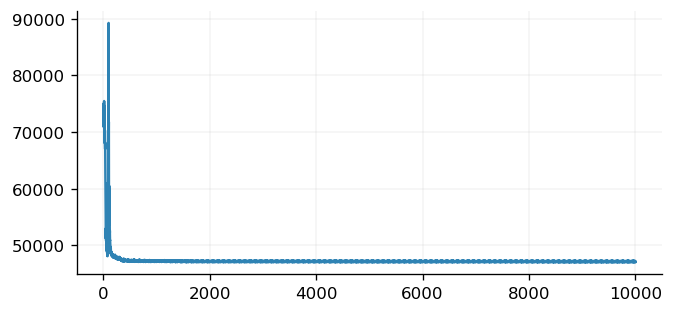

In [16]:
plt.plot(loss_history);

# Predict

In [18]:
# TODO PREDICT

pm.compile_pymc